# i. Imports and load the data 

In [1]:
import re
from pathlib import Path
import os

from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import PolynomialFeatures
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import nfl_data_py as nfl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

n_cores = os.cpu_count()

In [2]:
train_data_path = Path('../data/processed/field_goal_data.parquet')
fg_attempts = (
    pd.read_parquet(train_data_path)
    .assign(
        iced_kicker=lambda x: x['iced_kicker'].astype(int)
    )
    .merge(
        pd.read_csv('../data/processed/stadium_elevations.csv')
            [['stadium_id','elevation_feet']],
        on='stadium_id',
        how='left'
    )
)
fg_attempts.head()

,season,week,game_id,play_id,game_date,start_time,time_of_day,qtr,quarter_seconds_remaining,game_seconds_remaining,stadium,stadium_id,is_home,is_indoor,roof,grass_surface,lighting_condition,posteam,defteam,posteam_score,defteam_score,score_differential,kicker_player_name,kicker_player_id,kicker_headshot_url,kicker_height,kicker_weight,kicker_years_exp,kicker_draft_number,kicker_age,kicker_rich_hill,temperature,chance_of_rain,snow_severity,wind_speed,wind_gust,yardline_100,tie_or_take_lead,to_stay_within_one_score,pressure_rating,iced_kicker,field_goal_result,elevation_feet
0,2010,1,2010_01_GB_PHI,660.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T20:37:49Z,1.0,268.0,2968.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,GB,0.0,0.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,27.0,1,0,0.0,0,made,33
1,2010,1,2010_01_GB_PHI,3652.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T23:14:33Z,4.0,346.0,346.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,GB,17.0,27.0,-10.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,5.0,0,1,1.0,0,made,33
2,2010,4,2010_04_WAS_PHI,865.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T20:54:58Z,2.0,900.0,2700.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,WAS,0.0,14.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,31.0,0,0,0.0,0,made,33
3,2010,4,2010_04_WAS_PHI,1680.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T21:35:05Z,2.0,23.0,1823.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,WAS,3.0,17.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,6.0,0,0,0.0,0,made,33
4,2010,5,2010_05_PHI_SF,986.0,2010-10-10,"10/10/10, 20:30:42",2010-10-11T01:09:05Z,2.0,705.0,2505.0,Candlestick Park,SFO00,-1,0,outdoors,1,2,PHI,SF,7.0,7.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.836,0.5,71.0,0.0,0,10.0,10.0,14.0,1,0,0.0,0,made,35


In [3]:
fg_attempts.field_goal_result.value_counts(normalize=False)

made       13801
missed      2262
blocked      335
Name: field_goal_result, dtype: int64

# ii. Blocked field goals
Will not include these in the FG Make probability model, as it could add noise when trying to learn kicker skill. Blocks could be partially due to a kickers low launch angle, variance wiht a defender getting lucky with hand placement, or a poor block. Two of the three of those are out of the kickers control.

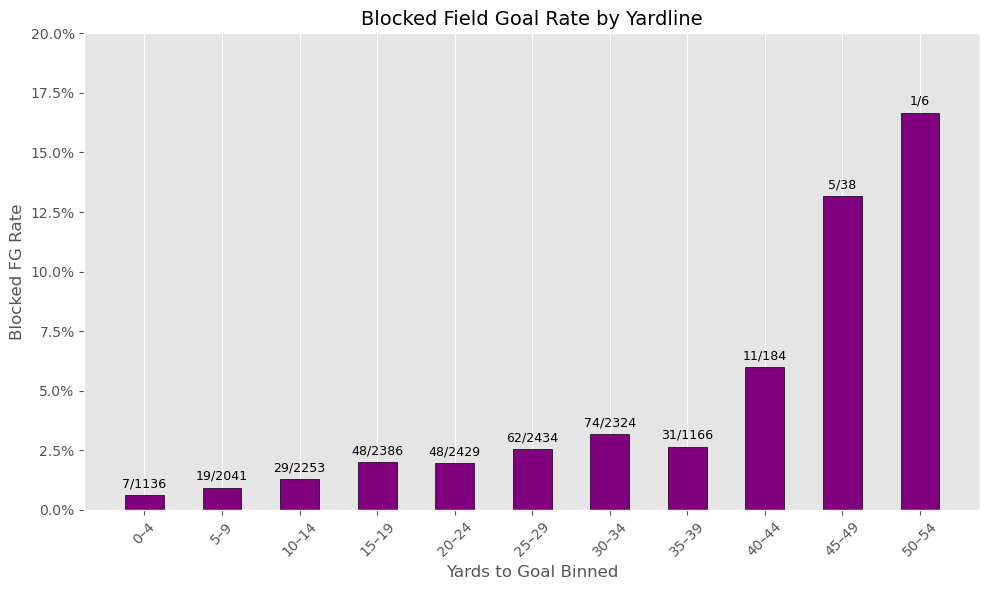

In [4]:
cpy = fg_attempts[['yardline_100', 'field_goal_result']].copy()

# Bin yardlines into 5-yard intervals
bins = np.arange(0, 60, 5)
cpy['yardline_bin'] = pd.cut(cpy['yardline_100'], bins=bins, right=False)

# Count total FG attempts and blocked FGs per bin
bin_totals = cpy.groupby('yardline_bin').size()
blocked_counts = cpy.query('field_goal_result == "blocked"').groupby('yardline_bin').size()

# Fill missing blocked counts with 0 for bins with no blocked FGs
blocked_counts = blocked_counts.reindex(bin_totals.index, fill_value=0)

# Calculate blocked rate
blocked_rate = blocked_counts / bin_totals

# Plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

bar_container = ax.bar(
    range(len(blocked_rate)), 
    blocked_rate.values, 
    width=0.5, 
    color='purple', 
    edgecolor='black'
)

# Add fraction labels on top of each bar
for i, (blocked, total, bar) in enumerate(zip(blocked_counts.values, bin_totals.values, bar_container)):
    label = f'{int(blocked)}/{int(total)}'
    ax.text(bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.002, 
            label, 
            ha='center', va='bottom', fontsize=9)

# Set custom x-axis labels
bin_labels = [f'{int(interval.left)}–{int(interval.right - 1)}' for interval in blocked_rate.index]
ax.set_xticks(range(len(bin_labels)))
ax.set_xticklabels(bin_labels, rotation=45)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.1f}%'))

ax.set_title('Blocked Field Goal Rate by Yardline', fontsize=14)
ax.set_xlabel('Yards to Goal Binned')
ax.set_ylabel('Blocked FG Rate')
ax.set_ylim(0, blocked_rate.max() * 1.2)
ax.grid(axis='y')
plt.tight_layout()
plt.show()


# iii. EDA

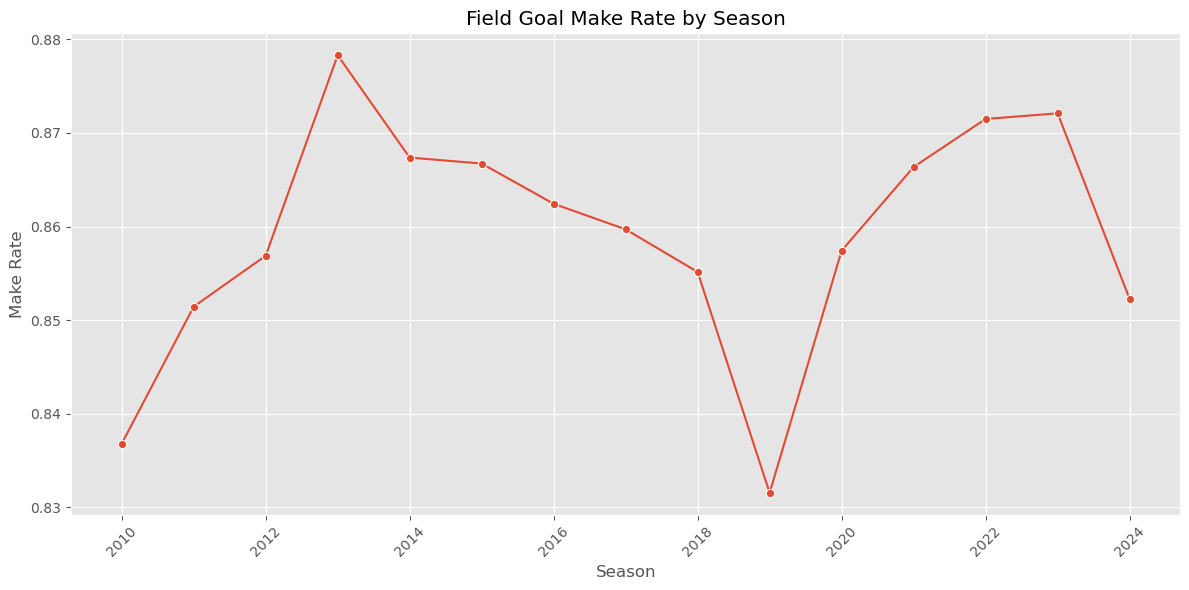

In [5]:
# plot the fg make rate by season
fg_make_rate = fg_attempts.groupby('season').field_goal_result.value_counts(normalize=True).unstack().fillna(0)
fg_make_rate['make_rate'] = fg_make_rate['made'] / (fg_make_rate['made'] + fg_make_rate['missed'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=fg_make_rate, x='season', y='make_rate', marker='o')
plt.title('Field Goal Make Rate by Season')
plt.xlabel('Season')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

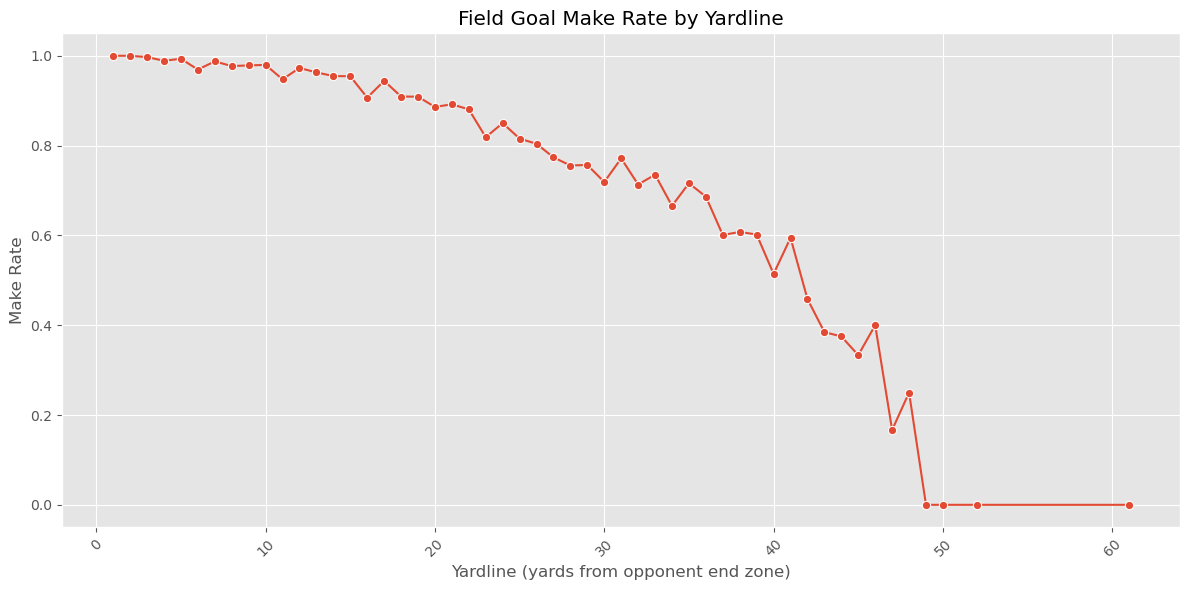

In [6]:
# plot fg make rate by yardline
fg_make_rate_yardline = fg_attempts.groupby('yardline_100').field_goal_result.value_counts(normalize=True).unstack().fillna(0)
fg_make_rate_yardline['make_rate'] = fg_make_rate_yardline['made'] / (fg_make_rate_yardline['made'] + fg_make_rate_yardline['missed'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=fg_make_rate_yardline, x='yardline_100', y='make_rate', marker='o')
plt.title('Field Goal Make Rate by Yardline')
plt.xlabel('Yardline (yards from opponent end zone)')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show() 

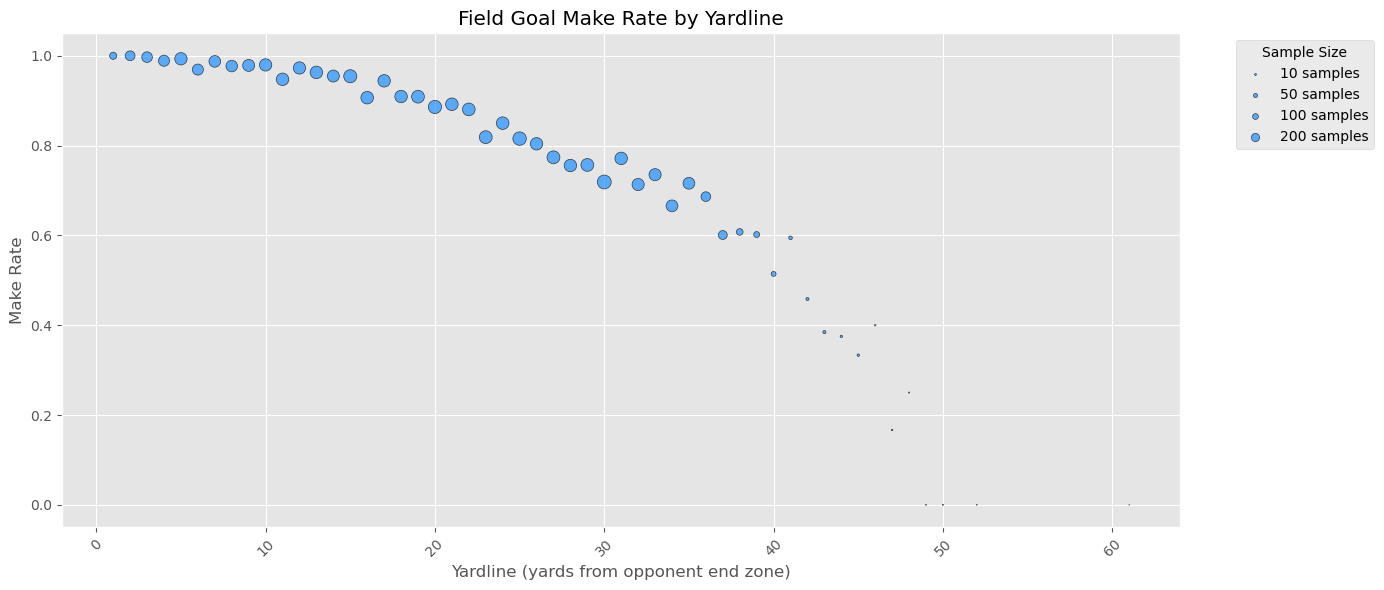

In [7]:
# Plot FG make rate by yardline, with marker size proportional to sample size and a legend for sample sizes

fg_make_rate_yardline = (
    fg_attempts.groupby('yardline_100').field_goal_result.value_counts(normalize=True)
    .unstack().fillna(0)
)
fg_make_rate_yardline['make_rate'] = fg_make_rate_yardline['made'] / (
    fg_make_rate_yardline['made'] + fg_make_rate_yardline['missed']
)
fg_make_rate_yardline['sample_size'] = (
    fg_attempts.groupby('yardline_100').size()
)

plt.figure(figsize=(12, 6))
sizes = fg_make_rate_yardline['sample_size']
# Normalize sizes for plotting (adjust scale as needed)
size_scale = 100
marker_sizes = size_scale * (sizes / sizes.max())

scatter = plt.scatter(
    fg_make_rate_yardline.index,
    fg_make_rate_yardline['make_rate'],
    s=marker_sizes,
    alpha=0.7,
    c='dodgerblue',
    edgecolor='black',
    label='FG Make Rate'
)

plt.title('Field Goal Make Rate by Yardline')
plt.xlabel('Yardline (yards from opponent end zone)')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Create a legend for sample sizes
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Choose representative sample sizes for legend
legend_sizes = [10, 50, 100, 200]
handles = [
    plt.scatter([], [], s=size_scale * (n / sizes.max()), color='dodgerblue', edgecolor='black', alpha=0.7,
                label=f'{n} samples')
    for n in legend_sizes
]
plt.legend(handles=handles, title='Sample Size', loc='upper right', bbox_to_anchor=(1.18, 1))

plt.show()

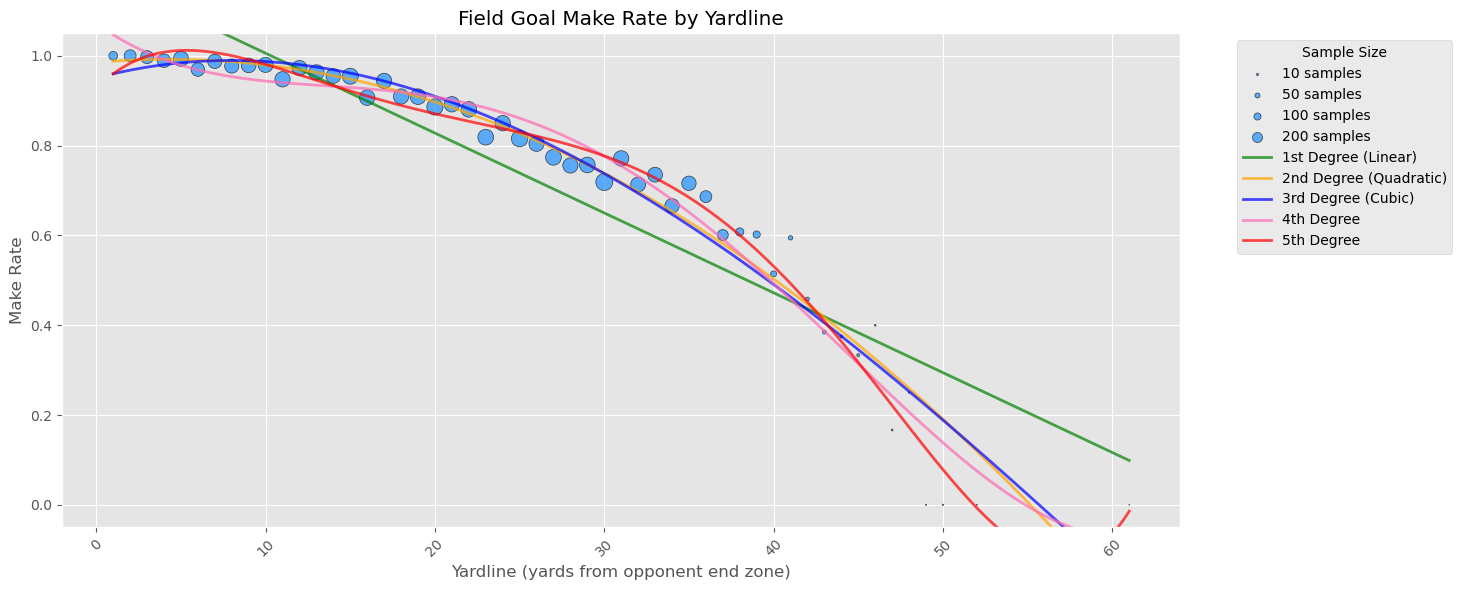

In [8]:
fg_make_rate_yardline = (
    fg_attempts.groupby('yardline_100').field_goal_result.value_counts(normalize=True)
    .unstack().fillna(0)
)
fg_make_rate_yardline['make_rate'] = fg_make_rate_yardline['made'] / (
    fg_make_rate_yardline['made'] + fg_make_rate_yardline['missed']
)
fg_make_rate_yardline['sample_size'] = (
    fg_attempts.groupby('yardline_100').size()
)

plt.figure(figsize=(12, 6))
sizes = fg_make_rate_yardline['sample_size']
size_scale = 150
marker_sizes = size_scale * (sizes / sizes.max())

scatter = plt.scatter(
    fg_make_rate_yardline.index,
    fg_make_rate_yardline['make_rate'],
    s=marker_sizes,
    alpha=0.7,
    c='dodgerblue',
    edgecolor='black',
    label='FG Make Rate'
)

x = np.array(fg_make_rate_yardline.index)
y = fg_make_rate_yardline['make_rate'].values
x_fit = np.linspace(x.min(), x.max(), 1000)

# Fit and plot polynomials of degree 1 to 5
colors = ['green', 'orange', 'blue', 'hotpink', 'red']
labels = [
    '1st Degree (Linear)',
    '2nd Degree (Quadratic)',
    '3rd Degree (Cubic)',
    '4th Degree',
    '5th Degree'
]
for deg, color, label in zip(range(1, 6), colors, labels):
    coeffs = np.polyfit(x, y, deg)
    poly = np.poly1d(coeffs)
    y_fit = poly(x_fit)
    plt.plot(x_fit, y_fit, color=color, linewidth=2, label=label, alpha=0.7)

plt.title('Field Goal Make Rate by Yardline')
plt.xlabel('Yardline (yards from opponent end zone)')
plt.ylabel('Make Rate')
plt.ylim(-.05, 1.05)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

import matplotlib.lines as mlines
legend_sizes = [10, 50, 100, 200]
handles = [
    plt.scatter([], [], s=size_scale * (n / sizes.max()), color='dodgerblue', edgecolor='black', alpha=0.7,
                label=f'{n} samples')
    for n in legend_sizes
]
# Add polynomial lines to legend
for color, label in zip(colors, labels):
    handles.append(mlines.Line2D([], [], color=color, linewidth=2, label=label, alpha=0.7))
plt.legend(handles=handles, title='Sample Size', loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

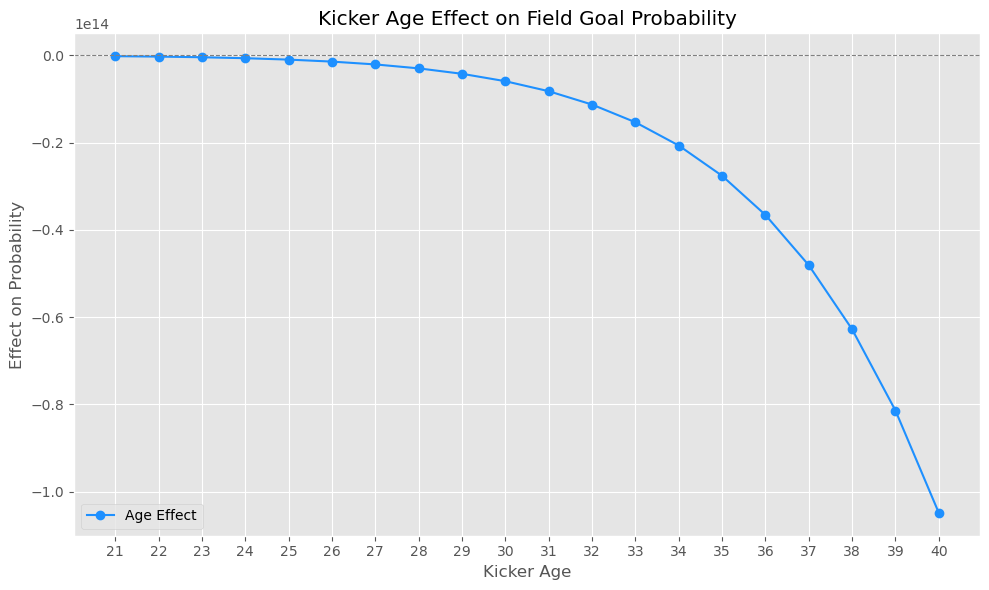

In [9]:
# plot this from ages 21-40: y = .1 * age - .05 * age^10
ages = np.arange(21, 41)
age_effect = 0.08 * ages - 0.01 * (ages **10)    
plt.figure(figsize=(10, 6))
plt.plot(ages, age_effect, marker='o', color='dodgerblue', label='Age Effect')
plt.title('Kicker Age Effect on Field Goal Probability')
plt.xlabel('Kicker Age')
plt.ylabel('Effect on Probability')
plt.xticks(ages)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

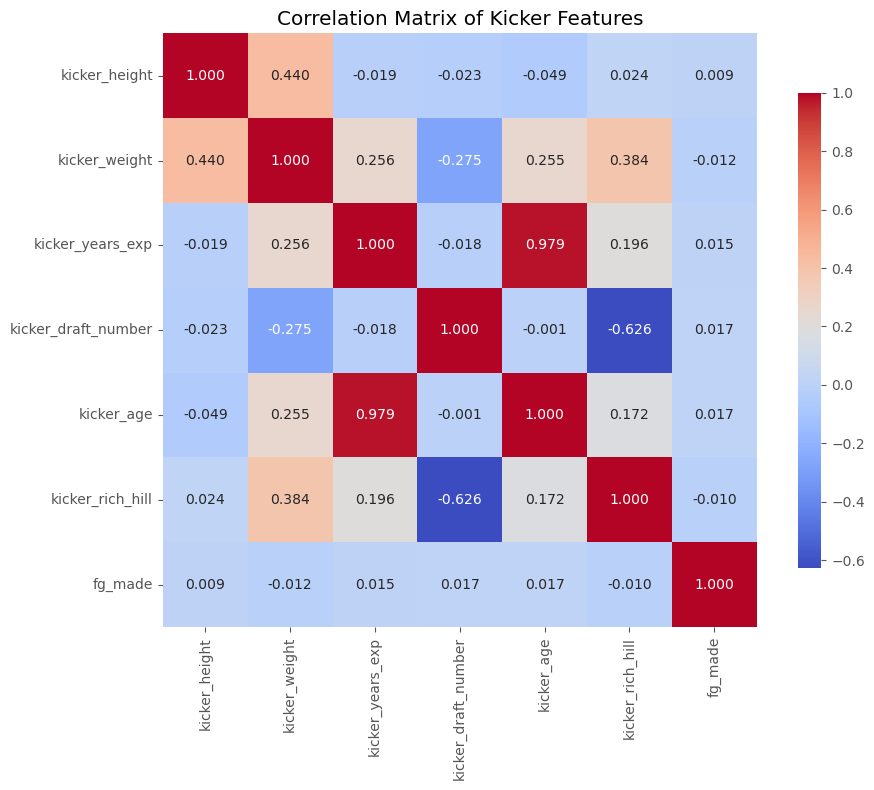

In [10]:
kicker_features = [
    'kicker_height', 'kicker_weight', 'kicker_years_exp', 'kicker_draft_number', 
    'kicker_age', 'kicker_rich_hill'
]
kicks = (
    fg_attempts
    .assign(
        fg_made = lambda x: x['field_goal_result'].eq('made').astype(int),
    )
    [kicker_features + ['fg_made']]
    .copy()
)

# correlation matrix
corr_matrix = kicks.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Kicker Features')
plt.tight_layout()
plt.show()

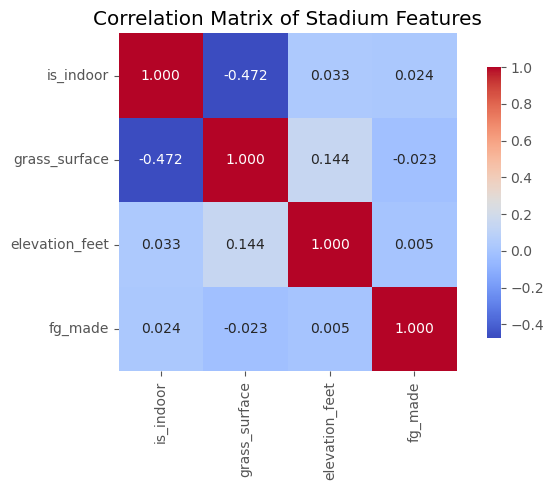

In [11]:
stadium_features = [
    'is_indoor', 'grass_surface', 'elevation_feet',
]
kicks = (
    fg_attempts
    .assign(
        fg_made = lambda x: x['field_goal_result'].eq('made').astype(int),
    )
    [stadium_features + ['fg_made']]
    .copy()
)

# correlation matrix
corr_matrix = kicks.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Stadium Features')
plt.tight_layout()
plt.show()

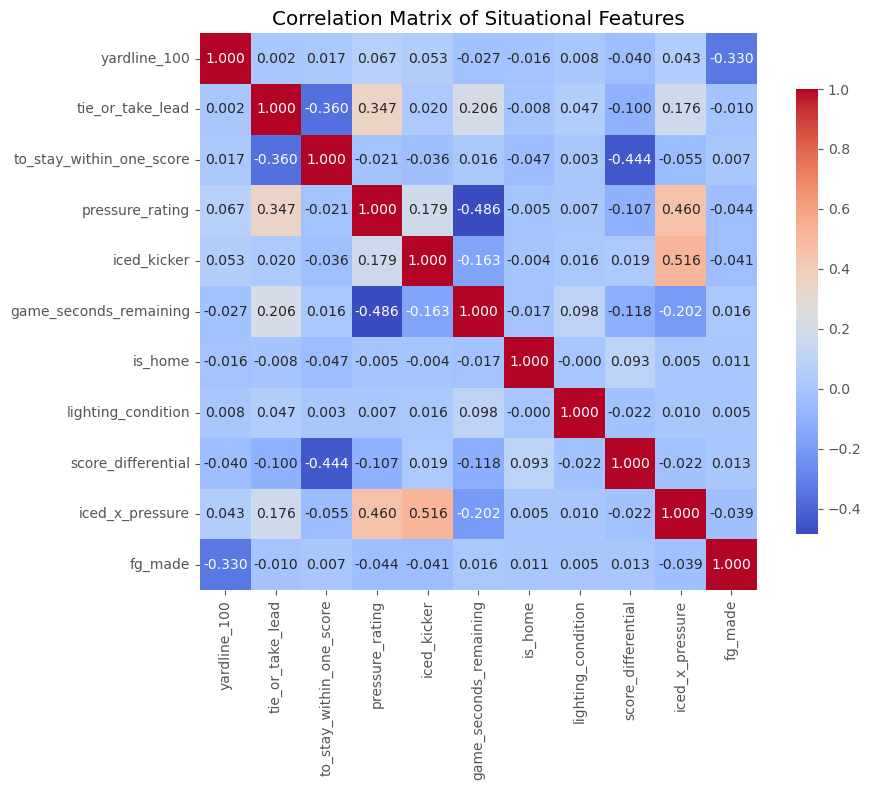

In [12]:
situational_features = [
    'yardline_100', 'tie_or_take_lead', 'to_stay_within_one_score', 'pressure_rating', 
    'iced_kicker', 'game_seconds_remaining', 'is_home', 'lighting_condition', 'score_differential'
]
kicks = (
    fg_attempts
    .assign(
        fg_made = lambda x: x['field_goal_result'].eq('made').astype(int),
        iced_x_pressure = lambda x: x['iced_kicker'] * x['pressure_rating']  # Interaction term
    )
    [situational_features + ['iced_x_pressure', 'fg_made']]
    .copy()
)

# correlation matrix
corr_matrix = kicks.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Situational Features')
plt.tight_layout()
plt.show()


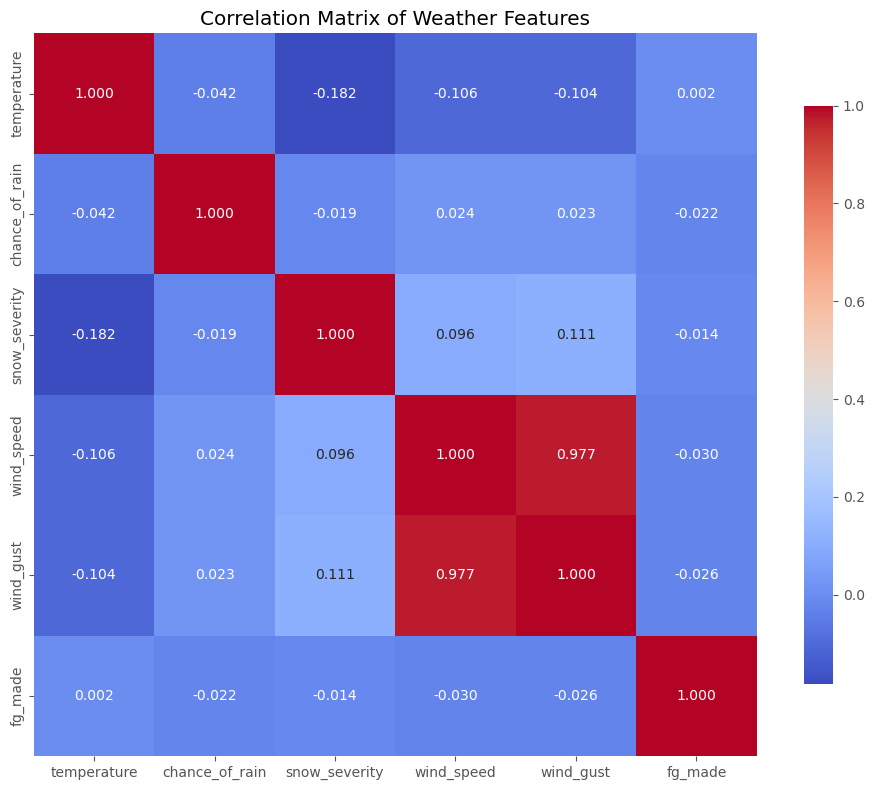

In [13]:
weather_features = [
    'temperature', 'chance_of_rain', 'snow_severity', 'wind_speed', 'wind_gust'
]
outdoor_kicks = (
    fg_attempts
    .query('is_indoor == 0') # Outdoor kicks only
    .assign(
        fg_made = lambda x: x['field_goal_result'].eq('made').astype(int),
    )
    [weather_features + ['fg_made']]
    .copy()
)

# correlation matrix
corr_matrix = outdoor_kicks.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Weather Features')
plt.tight_layout()
plt.show()

##### Using 2nd degree polynomial yards to goal because it creates a more linear relationship with FG Percentage

R-squared between yardline squared and FG made: 0.1157


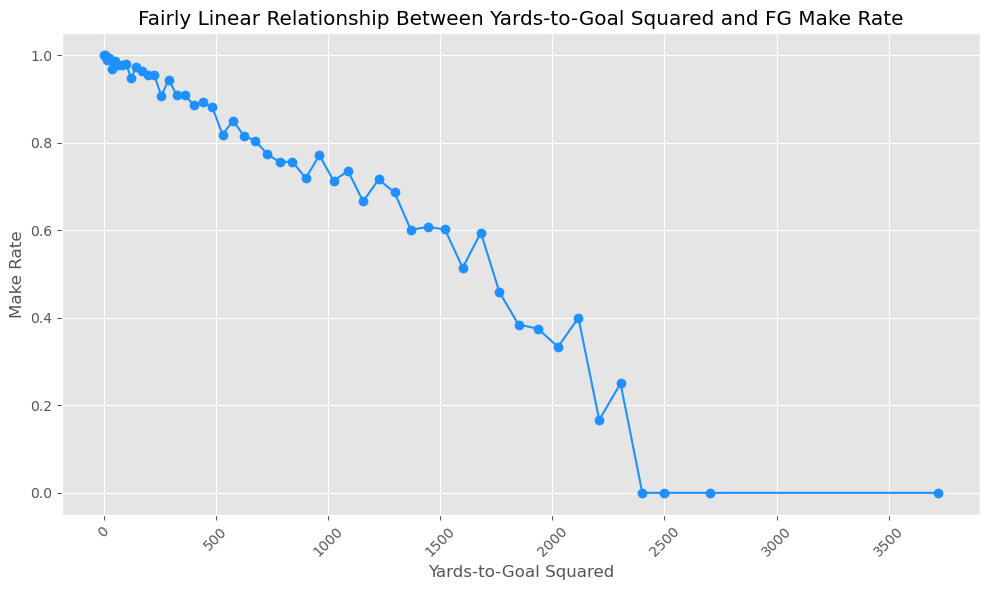

In [17]:
# plot ytg **2 vs fg make rate
ytg_2 = fg_attempts['yardline_100'] ** 2
# r squared between ytg_2 and fg made
fg_made = fg_attempts['field_goal_result'].eq('made').astype(int)
r_squared = np.corrcoef(ytg_2, fg_made)[0, 1] ** 2
print(f"R-squared between yardline squared and FG made: {r_squared:.4f}")
fg_make_rate_yardline_poly2 = (
    fg_attempts.groupby(ytg_2).field_goal_result.value_counts(normalize=True)
    .unstack().fillna(0)
)
fg_make_rate_yardline_poly2['make_rate'] = fg_make_rate_yardline_poly2['made'] / (
    fg_make_rate_yardline_poly2['made'] + fg_make_rate_yardline_poly2['missed']
)
plt.figure(figsize=(10, 6))
plt.plot(
    fg_make_rate_yardline_poly2.index, 
    fg_make_rate_yardline_poly2['make_rate'], 
    marker='o', 
    color='dodgerblue'
)
plt.title('Fairly Linear Relationship Between Yards-to-Goal Squared and FG Make Rate')
plt.xlabel('Yards-to-Goal Squared')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
fg_made = fg_attempts['field_goal_result'].eq('made').astype(int)
for degree in range(1, 6):
    ytg_poly = fg_attempts['yardline_100'] ** degree
    r_squared = np.corrcoef(ytg_poly, fg_made)[0, 1] ** 2
    print(f"R-squared between yardline^{degree} and FG made: {r_squared:.4f}")

R-squared between yardline^1 and FG made: 0.1090
R-squared between yardline^2 and FG made: 0.1157
R-squared between yardline^3 and FG made: 0.1112
R-squared between yardline^4 and FG made: 0.1013
R-squared between yardline^5 and FG made: 0.0879
